Device: cpu
Test size: 20


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best threshold = 0.44999999999999996 → F1 = 0.692
Confusion matrix (TN, FP / FN, TP)
 [[3 7]
 [1 9]]


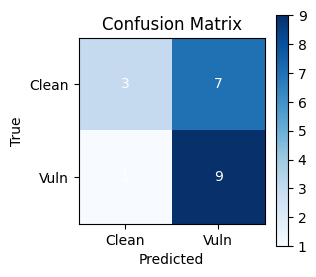

Average latency = 334.0 ms/function
✅ Report saved → reports\eval_2025-06-12.md


In [3]:
# %% [markdown]
# ## Task 5 – Evaluation & Threshold Sweep
# Uses the `test.jsonl` split to measure real-world performance and pick an
# operating threshold for the live scanner.

# %% [code] ▸ 0 Imports & paths
import json, pathlib, datetime
import numpy as np, pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import (
    precision_recall_fscore_support, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import torch, time

from src.eval_utils import load_adapter, batched_logits

MODEL_DIR  = pathlib.Path("../models/codebert_mini_lora")
TEST_FILE  = pathlib.Path("../data/splits/test.jsonl")
REPORT_DIR = pathlib.Path("reports"); REPORT_DIR.mkdir(exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# %% [code] ▸ 1 Load test split
with TEST_FILE.open() as f:
    records = [json.loads(l) for l in f]
df = pd.DataFrame(records)
print("Test size:", len(df))

# %% [code] ▸ 2 Load model + tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model     = load_adapter(MODEL_DIR, device=DEVICE)

# %% [code] ▸ 3 Get logits & probabilities
logits = batched_logits(model, tokenizer, df["Function before"].tolist(),
                        batch_size=16, device=DEVICE)
prob_vuln = torch.softmax(torch.tensor(logits), dim=-1)[:,1].numpy()
df["prob_vuln"] = prob_vuln

# %% [code] ▸ 4 Threshold sweep
ths  = np.linspace(0.05, 0.95, 19)
rows = []
y_true = df["is_vuln"].values
for t in ths:
    y_pred = (prob_vuln >= t).astype(int)
    p,r,f,_ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    rows.append(dict(threshold=t, precision=p, recall=r, f1=f))
sweep = pd.DataFrame(rows)
best_row = sweep.loc[sweep.f1.idxmax()]
best_t   = best_row.threshold
print("Best threshold =", best_t, "→ F1 =", best_row.f1.round(3))

# %% [code] ▸ 5 Confusion matrix at best-t
y_pred_best = (prob_vuln >= best_t).astype(int)
cm = confusion_matrix(y_true, y_pred_best)
print("Confusion matrix (TN, FP / FN, TP)\n", cm)

# quick visual
plt.figure(figsize=(3,3))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix"); plt.colorbar()
for (i,j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha="center", va="center", color="white")
plt.xticks([0,1],["Clean","Vuln"]); plt.yticks([0,1],["Clean","Vuln"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# %% [code] ▸ 6 Latency test (100 slices)
n_lat_test = min(100, len(df))
subset = (
    df["Function before"]
      .sample(n_lat_test, random_state=42, replace=False)   # safe now
      .tolist()
)

t0 = time.time()
_   = batched_logits(model, tokenizer, subset, batch_size=16, device=DEVICE)
lat = (time.time() - t0) / len(subset)
print(f"Average latency = {lat*1000:.1f} ms/function")

# %% [code] ▸ 7 Write markdown report
stamp = datetime.datetime.now().strftime("%Y-%m-%d")
md = REPORT_DIR / f"eval_{stamp}.md"
with md.open("w") as w:
    w.write(f"# Evaluation – {stamp}\n\n")
    w.write(f"**Best threshold**: `{best_t:.2f}`\n\n")
    w.write(sweep.to_markdown(index=False))
    w.write("\n\n```text\n")
    w.write(classification_report(y_true, y_pred_best, digits=3))
    w.write("\n```\n")
    w.write(f"\nConfusion matrix:\n\n```\n{cm}\n```\n")
    w.write(f"\nAverage latency: {lat*1000:.1f} ms/function\n")

print("✅ Report saved →", md)
# %% [markdown] ----------------------------------------------------------
# Task 5 – CVSS Regressor
# Uses the frozen CodeBERT encoder + a 2-layer MLP head to predict a
# CVSS v3 score (0–10).  Expected runtime: <15 min on RTX-3060.

# %% [code] 0 Imports & paths
